# Lab 2: Sampling

Welcome to Lab 2! In this lab, we will learn about sampling strategies. More information about sampling in the textbook can be found [here!](https://www.inferentialthinking.com/chapters/10/sampling-and-empirical-distributions.html)

The data used in this lab will contain salary data and statistics for basketball players from the 2014-2015 NBA season. This data was collected from [basketball-reference](http://www.basketball-reference.com) and [spotrac](http://www.spotrac.com).

In [31]:
# Run this cell, but please don't change it.

# These lines import the Numpy and Datascience modules.
import numpy as np
from datascience import *

# These lines do some fancy plotting magic
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

## 1. Dungeons and Dragons and Sampling
In the game Dungeons & Dragons, each player plays the role of a fantasy character.

A player performs actions by rolling a 20-sided die, adding a "modifier" number to the roll, and comparing the total to a threshold for success.  The modifier depends on her character's competence in performing the action.

For example, suppose Alice's character, a barbarian warrior named Roga, is trying to knock down a heavy door.  She rolls a 20-sided die, adds a modifier of 11 to the result (because her character is good at knocking down doors), and succeeds if the total is greater than 15.

** Question 1.1 ** <br/>Write code that simulates that procedure.  Compute three values: the result of Alice's roll (`roll_result`), the result of her roll plus Roga's modifier (`modified_result`), and a boolean value indicating whether the action succeeded (`action_succeeded`).  **Do not fill in any of the results manually**; the entire simulation should happen in code.

*Hint:* A roll of a 20-sided die is a number chosen uniformly from the array `make_array(1, 2, 3, 4, ..., 20)`.  So a roll of a 20-sided die *plus 11* is a number chosen uniformly from that array, plus 11.

In [32]:
possible_rolls = np.arange(1,21)
roll_result = np.random.choice(possible_rolls)
modified_result = roll_result + 11
action_succeeded = modified_result > 15

# The next line just prints out your results in a nice way
# once you're done.  You can delete it if you want.
print("On a modified roll of {:d}, Alice's action {}.".format(modified_result, "succeeded" if action_succeeded else "failed"))

On a modified roll of 14, Alice's action failed.


** Question 1.2 ** <br/>Run your cell 7 times to manually estimate the chance that Alice succeeds at this action.  (Don't use math or an extended simulation.). Your answer should be a fraction. 

In [33]:
rough_success_chance = (1+1+1+1+0+0+1)/7
rough_success_chance

0.7142857142857143

Suppose we don't know that Roga has a modifier of 11 for this action.  Instead, we observe the modified roll (that is, the die roll plus the modifier of 11) from each of 7 of her attempts to knock down doors.  We would like to estimate her modifier from these 7 numbers.

** Question 1.3 ** <br/>Write a Python function called `simulate_observations`.  It should take no arguments, and it should return an array of 7 numbers.  Each of the numbers should be the modified roll from one simulation.  **Then**, call your function once to compute an array of 7 simulated modified rolls.  Name that array `observations`.

In [34]:
modifier = 11
num_observations = 7

def simulate_observations():
    """Produces an array of 7 simulated modified die rolls"""
    return np.random.choice(np.arange(1,21)+modifier,num_observations)

observations = simulate_observations()
observations

array([15, 27, 27, 28, 31, 31, 14])

** Question 1.4 ** <br/>Draw a histogram to display the *probability distribution* of the modified rolls we might see.

Question 1.4 does not have an autograder test, so it is not graded and not in the overall lab grade.

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


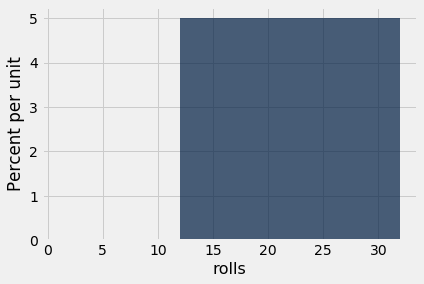

In [35]:
# We suggest using these bins.
roll_bins = np.arange(1, modifier+2+20, 1)
num = Table().with_columns("rolls",np.arange(1+modifier, 20+modifier+1))
num.hist("rolls",bins = roll_bins)

Your histogram should have values 12 to 31 each with a probability of 5%.

Now let's imagine we don't know the modifier and try to estimate it from `observations`.

One straightforward (but clearly suboptimal) way to do that is to find the *smallest* total roll, since the smallest roll on a 20-sided die is 1.

** Question 1.5 ** <br/>Using that method, estimate `modifier` from `observations`.  Name your estimate `min_estimate`.

In [36]:
min_estimate = min(observations-1)
min_estimate

13

Another way to estimate the modifier involves the mean of `observations`.

** Question 1.6 ** <br/>Figure out a good estimate based on that quantity.  

**Then**, write a function named `mean_based_estimator` that computes your estimate.  It should take an array of modified rolls (like the array `observations`) as its argument and return an estimate of `modifier` based on those numbers.

In [37]:
def mean_based_estimator(nums):
    """Estimate the roll modifier based on observed modified rolls in the array nums."""
    return np.average(nums)-np.average(np.arange(1,21))

# Here is an example call to your function.  It computes an estimate
# of the modifier from our 7 observations.
mean_based_estimate = mean_based_estimator(observations)
mean_based_estimate

14.214285714285715

## 2. Sampling

Run the cell below to load the player and salary data.

In [38]:
player_data = Table().read_table("player_data.csv")
salary_data = Table().read_table("salary_data.csv")
full_data = salary_data.join("PlayerName", player_data, "Name")
# The show method immediately displays the contents of a table. 
# This way, we can display the top of two tables using a single cell.
player_data.show(3)
salary_data.show(3)
full_data.show(3)

Name,Age,Team,Games,Rebounds,Assists,Steals,Blocks,Turnovers,Points
James Harden,25,HOU,81,459,565,154,60,321,2217
Chris Paul,29,LAC,82,376,838,156,15,190,1564
Stephen Curry,26,GSW,80,341,619,163,16,249,1900


PlayerName,Salary
Kobe Bryant,23500000
Amar'e Stoudemire,23410988
Joe Johnson,23180790


PlayerName,Salary,Age,Team,Games,Rebounds,Assists,Steals,Blocks,Turnovers,Points
A.J. Price,62552,28,TOT,26,32,46,7,0,14,133
Aaron Brooks,1145685,30,CHI,82,166,261,54,15,157,954
Aaron Gordon,3992040,19,ORL,47,169,33,21,22,38,243


Rather than getting data on every player, imagine that we had gotten data on only a smaller subset of the players.  For 492 players, it's not so unreasonable to expect to see all the data, but usually we aren't so lucky.  Instead, we often make *statistical inferences* about a large underlying population using a smaller sample.

A statistical inference is a statement about some statistic of the underlying population, such as "the average salary of NBA players in 2014 was $3".  You may have heard the word "inference" used in other contexts.  It's important to keep in mind that statistical inferences, unlike, say, logical inferences, can be wrong.

A general strategy for inference using samples is to estimate statistics of the population by computing the same statistics on a sample.  This strategy sometimes works well and sometimes doesn't.  The degree to which it gives us useful answers depends on several factors, and we'll touch lightly on a few of those today.

One very important factor in the utility of samples is how they were gathered.  We have prepared some example sample datasets to simulate inference from different kinds of samples for the NBA player dataset.  Later we'll ask you to create your own samples to see how they behave.

To save typing and increase the clarity of your code, we will package the loading and analysis code into two functions. This will be useful in the rest of the lab as we will repeatedly need to create histograms and collect summary statistics from that data.

**Question 2.1**. <br/>Complete the `histograms` function, which takes a table with columns `Age` and `Salary` and draws a histogram for each one. Use the min and max functions to pick the bin boundaries so that all data appears for any table passed to your function. Use the same bin widths as before (1 year for `Age` and $1,000,000 for `Salary`).

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Two histograms should be displayed below


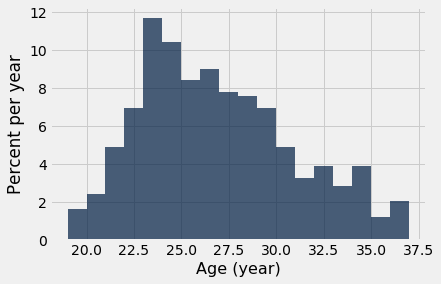

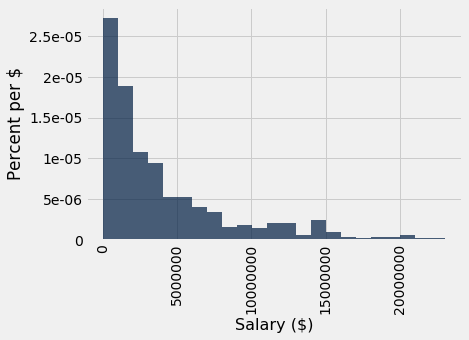

In [39]:
def histograms(t):
    ages = t.column('Age')
    salaries = t.column('Salary')
    age_bins = np.arange(min(t.column("Age")),max(t.column("Age")),1)
    salary_bins = np.arange(min(t.column("Salary")),max(t.column("Salary")),1000000)
    t.hist('Age', bins=age_bins, unit='year')
    t.hist('Salary', bins=salary_bins, unit='$')
    return age_bins # Keep this statement so that your work can be checked
    
histograms(full_data)
print('Two histograms should be displayed below')

**Question 2.2**. <br/>Create a function called `compute_statistics` that takes a Table containing ages and salaries and:
- Draws a histogram of ages
- Draws a histogram of salaries
- Returns a two-element array containing the average age and average salary

You can call your `histograms` function to draw the histograms!

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


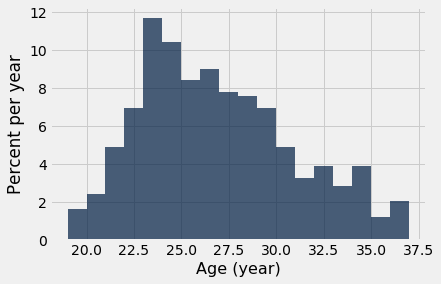

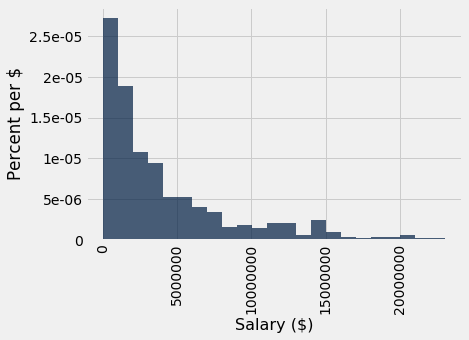

In [40]:
def compute_statistics(t):
    ages = t.column('Age')
    salaries = t.column('Salary')
    age_bins = np.arange(min(t.column("Age")),max(t.column("Age")),1)
    salary_bins = np.arange(min(t.column("Salary")),max(t.column("Salary")),1000000)
    t.hist('Age', bins=age_bins, unit='year')
    t.hist('Salary', bins=salary_bins, unit='$')
    age = np.average(t.column("Age"))
    salary = np.average(t.column("Salary"))
    a_and_s = make_array(age,salary)
    return a_and_s
    

full_stats = compute_statistics(full_data)

### Convenience sampling
One sampling methodology, which is **generally a bad idea**, is to choose players who are somehow convenient to sample.  For example, you might choose players from one team that's near your house, since it's easier to survey them.  This is called, somewhat pejoratively, *convenience sampling*.

Suppose you survey only *relatively new* players with ages less than 22.  (The more experienced players didn't bother to answer your surveys about their salaries.)

**Question 2.3**  <br/>Assign `convenience_sample_data` to a subset of `full_data` that contains only the rows for players under the age of 22.

In [41]:
convenience_sample = full_data.where("Age",are.below(22))
convenience_sample

PlayerName,Salary,Age,Team,Games,Rebounds,Assists,Steals,Blocks,Turnovers,Points
Aaron Gordon,3992040,19,ORL,47,169,33,21,22,38,243
Alex Len,3649920,21,PHO,69,454,32,34,105,74,432
Andre Drummond,2568360,21,DET,82,1104,55,73,153,120,1130
Andrew Wiggins,5510640,19,MIN,82,374,170,86,50,177,1387
Anthony Bennett,5563920,21,MIN,57,216,48,27,16,36,298
Anthony Davis,5607240,21,NOP,68,696,149,100,200,95,1656
Archie Goodwin,1112280,20,PHO,41,74,44,18,9,48,231
Ben McLemore,3026280,21,SAC,82,241,140,77,19,138,996
Bradley Beal,4505280,21,WAS,63,241,194,76,18,123,962
Bruno Caboclo,1458360,19,TOR,8,2,0,0,1,4,10


**Question 2.4** <br/>Assign `convenience_stats` to a list of the average age and average salary of your convenience sample, using the `compute_statistics` function.  Since they're computed on a sample, these are called *sample averages*. 

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


array([2.03636364e+01, 2.38353382e+06])

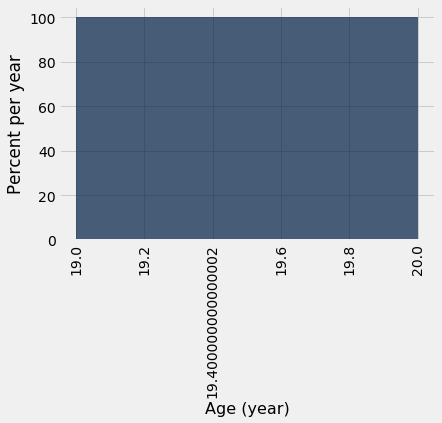

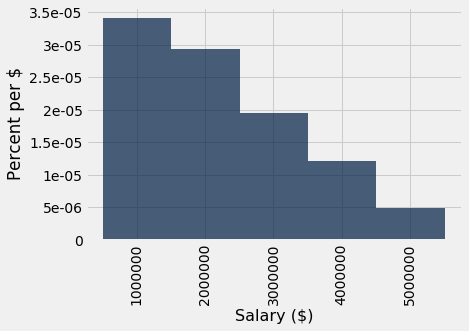

In [42]:
convenience_stats = compute_statistics(convenience_sample)
convenience_stats

Next, we'll compare the convenience sample salaries with the full data salaries in a single histogram. To do that, we'll need to use the `bin_column` option of the `hist` method, which indicates that all columns are counts of the bins in a particular column. The following cell should not require any changes; just run it.

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


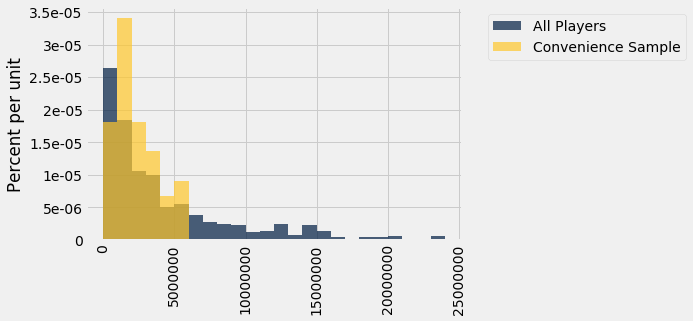

In [43]:
def compare_salaries(first, second, first_title, second_title):
    """Compare the salaries in two tables."""
    max_salary = max(np.append(first.column('Salary'), second.column('Salary')))
    bins = np.arange(0, max_salary+1e6+1, 1e6)
    first_binned = first.bin('Salary', bins=bins).relabeled(1, first_title)
    second_binned = second.bin('Salary', bins=bins).relabeled(1, second_title)
    first_binned.join('bin', second_binned).hist(bin_column='bin')

compare_salaries(full_data, convenience_sample, 'All Players', 'Convenience Sample')

### Simple random sampling
A more principled approach is to sample uniformly at random from the players.  If we ensure that each player is selected at most once, this is a *simple random sample without replacement*, sometimes abbreviated to "simple random sample" or "SRSWOR".  Imagine writing down each player's name on a card, putting the cards in an urn, and shuffling the urn.  Then, pull out cards one by one and set them aside, stopping when the specified *sample size* is reached.

We've produced two samples of the `salary_data` table in this way: `small_srswor_salary.csv` and `large_srswor_salary.csv` contain, respectively, a sample of size 44 (the same as the convenience sample) and a larger sample of size 100.  

The `load_data` function below loads a salary table and joins it with `player_data`.

In [44]:
def load_data(salary_file):
    return player_data.join('Name', Table.read_table(salary_file), 'PlayerName')

**Question 2.5** <br/>Run the same analyses on the small and large samples that you previously ran on the full dataset and on the convenience sample.  Compare the accuracy of the estimates of the population statistics that we get from the convenience sample, the small simple random sample, and the large simple random sample.  (Just notice this for yourself -- the autograder will check your sample statistics but will not validate whatever you do to compare.)

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Full data stats:                  [2.65365854e+01 4.26977577e+06]
Small simple random sample stats: [2.63181818e+01 4.28391089e+06]
Large simple random sample stats: [2.6420000e+01 4.8213225e+06]


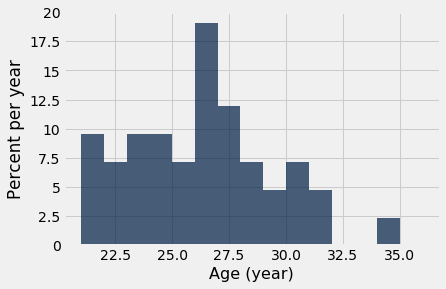

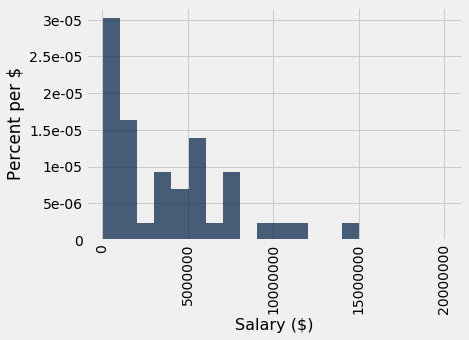

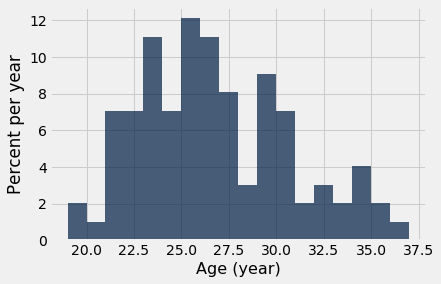

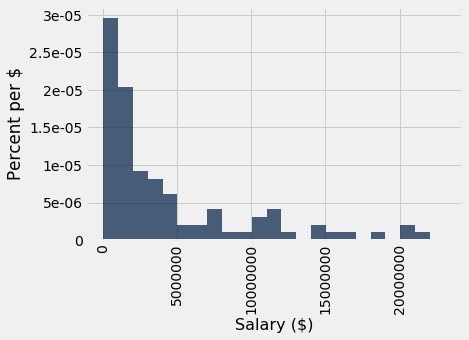

In [45]:
# Original:
small_srswor_data = load_data("small_srswor_salary.csv")
small_stats = compute_statistics(small_srswor_data)
large_srswor_data = load_data("large_srswor_salary.csv")
large_stats = compute_statistics(large_srswor_data)
print('Full data stats:                 ', full_stats)
print('Small simple random sample stats:', small_stats)
print('Large simple random sample stats:', large_stats)

### Producing simple random samples
Often it's useful to take random samples even when we have a larger dataset available.  The randomized response technique was one example we saw in lecture.  Another is to help us understand how inaccurate other samples are.

Tables provide the method `sample()` for producing random samples.  Note that its default is to sample with replacement. To see how to call `sample()`, search the documentation on the [resources page](http://data8.org/su17/resources.html) of the course website, or enter `full_data.sample?` into a code cell and press Shift + Enter.

**Question 2.6** <br/>
Produce a simple random sample of size 44 from `full_data`.  (You don't need to bother with a join this time -- just use `full_data.sample(...)` directly.  That will have the same result as sampling from `salary_data` and joining with `player_data`.)  Run your analysis on it again and think about these following questions.
- Are your results roughly similar to those in the small sample we provided you?  Run your code several times to get new samples.  
- How much does the average age change across samples? 
- What about average salary?

Question 2.6 does not have an autograder test, so it is not graded and not in the overall lab grade.

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


array([2.67500000e+01, 4.41239082e+06])

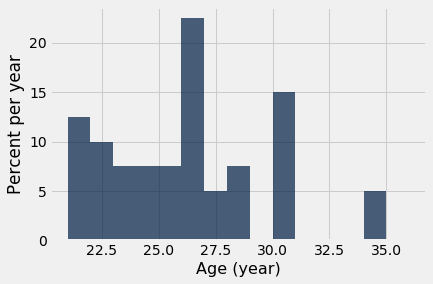

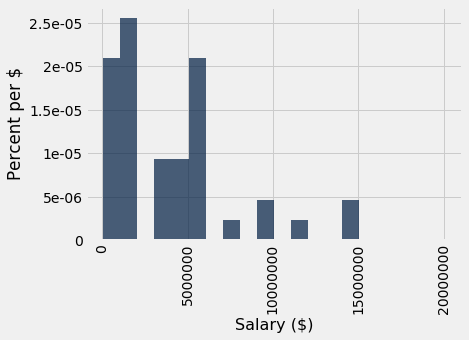

In [46]:
my_small_srswor_data = small_srswor_data.sample(44)
my_small_stats = compute_statistics(my_small_srswor_data)
my_small_stats

Notice that the results are similar, but not the same, to the sample we were given. The average age tends to stay around the same value as there is a limited range of ages for NBA players, but the salary changes by a sizeable factor due to larger variability in salary.

**Question 2.7** <br/>As in the previous question, analyze several simple random samples of size 100 from `full_data`.  
- Do the histogram statistics seem to change more or less across samples of 100 than across samples of size 44?  
- Are the sample averages and histograms closer to their true values for age or for salary?  What did you expect to see?

Question 2.7 does not have an autograder test, so it is not graded and not in the overall lab grade.

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


array([2.6980000e+01, 4.9624081e+06])

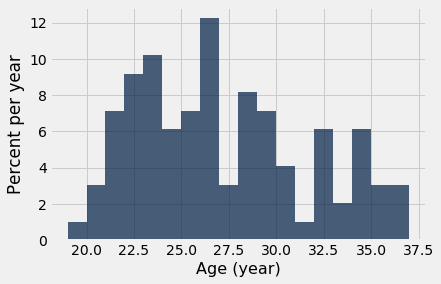

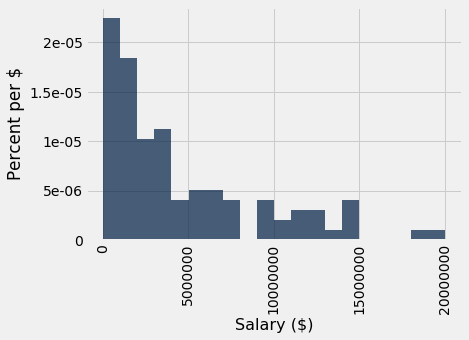

In [47]:
my_large_srswor_data = full_data.sample(100)
compute_statistics(my_large_srswor_data)

The average and histogram statistics seem to change less across samples of this size. They are closer to their true values, which is what we'd expect to see because we are sampling a larger subset of the population. 

## Submission

You're finished with lab 2! In order to successfully submit your assignment, follow these steps...
- **IMPORTANT** Before you do anything, **Save and Checkpoint** from the `File` menu. Please do this first before running the cell below,
- **run all the tests and verify that they all pass** (the next cell has a shortcut for that), 
- **Review the notebook one last time, we will be grading the final state of your notebook** If you make any changes, please **Save and Checkpoint** again.